In [1]:
# Create new conda environment called bravetrue with Python 3.12
# conda create -n bravetrue python=3.12


In [2]:
# https://matheusfacure.github.io/python-causality-handbook/landing-page.html
# https://github.com/matheusfacure/python-causality-handbook/tree/master/causal-inference-for-the-brave-and-true

In [3]:
from IPython.display import Image
from IPython.core.display import HTML

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression

from sklift.viz import plot_uplift_curve, plot_uplift_by_percentile
from sklift.metrics.metrics import uplift_auc_score


In [4]:
np.random.seed(123)


In [5]:
train = pd.read_csv("./data/invest_email_biased.csv")
test = pd.read_csv("./data/invest_email_rnd.csv")
train.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,0,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,0,0,1,1
3,39.7,2326.37,15657.97,6345.20,0,0,0,0
4,35.3,2787.26,27074.44,14114.86,1,1,0,0


In [6]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

# S-Learner

In [28]:
Image(url= "https://matheusfacure.github.io/python-causality-handbook/_images/s-learner.png", width=800)


In [7]:
s_learner = LGBMRegressor(max_depth=2, min_child_samples=30)
s_learner.fit(train[X+[T]], train[y])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 5
[LightGBM] [Info] Start training from score 0.200467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(max_depth=2, min_child_samples=30)

In [8]:
s_learner_cate_train = train.assign(cate=(s_learner.predict(train[X].assign(**{T: 1})) - s_learner.predict(train[X].assign(**{T: 0}))))

In [9]:
s_learner_cate_test = test.assign(cate=(s_learner.predict(test[X].assign(**{T: 1})) - s_learner.predict(test[X].assign(**{T: 0}))))

<Axes: xlabel='cate', ylabel='Count'>

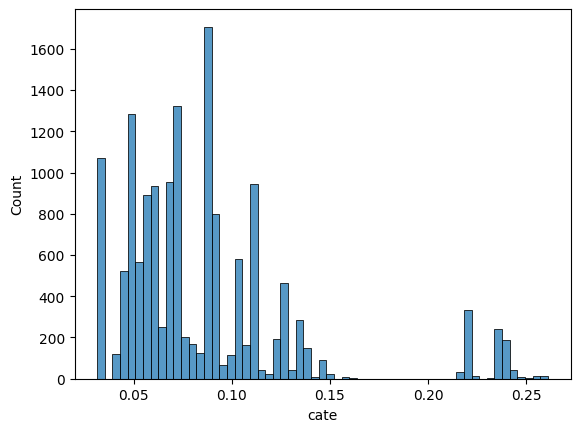

In [10]:
sns.histplot(s_learner_cate_test, x="cate")

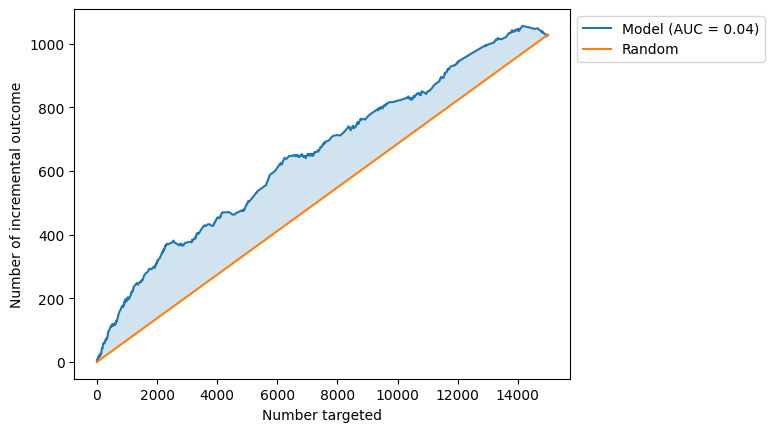

In [11]:
uplift_test = plot_uplift_curve(
    s_learner_cate_test["converted"], s_learner_cate_test["cate"], s_learner_cate_test["em1"],
    perfect=False, name='Model'
)

# T-Learner

In [30]:
Image(url= "https://matheusfacure.github.io/python-causality-handbook/_images/t-learner.png", width=800)


In [12]:
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = train.assign(cate=m1.predict(train[X]) - m0.predict(train[X]))
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 11630, number of used features: 4
[LightGBM] [Info] Start training from score 0.189596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 958
[LightGBM] [Info] Number of data points in the train set: 3370, number of used features: 4
[LightGBM] [Info] Start training from score 0.237982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

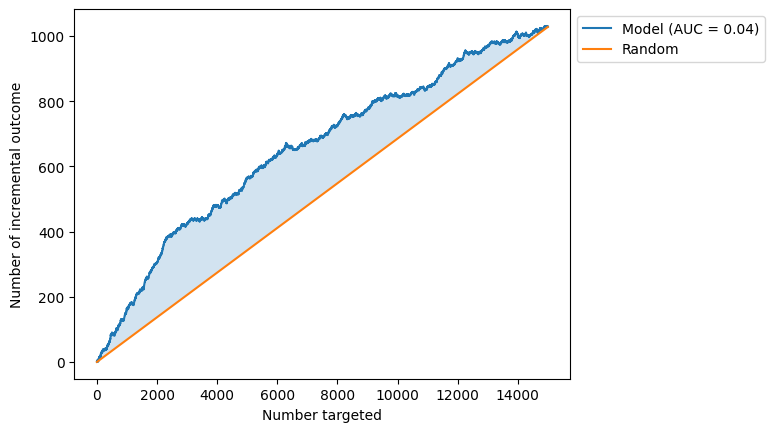

In [13]:
uplift_test = plot_uplift_curve(
    t_learner_cate_test["converted"], t_learner_cate_test["cate"], t_learner_cate_test["em1"],
    perfect=False, name='Model'
)

# X-Learner

In [27]:
Image(url= "https://matheusfacure.github.io/python-causality-handbook/_images/x-learner.png", width=800)

In [14]:
# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty=None)
g.fit(train[X], train[T])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 11630, number of used features: 4
[LightGBM] [Info] Start training from score 0.189596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 958
[LightGBM] [Info] Number of data points in the train set: 3370, number of used features: 4
[LightGBM] [Info] Start training from score 0.237982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

LogisticRegression(penalty=None)

In [15]:
# calc CATE
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))


In [16]:
# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1]);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 11630, number of used features: 4
[LightGBM] [Info] Start training from score 0.107760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 958
[LightGBM] [Info] Number of data points in the train set: 3370, number of used features: 4
[LightGBM] [Info] Start training from score 0.063810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [17]:
def ps_predict(df, t): 
    return g.predict_proba(df[X])[:, t]


In [18]:
x_learner_cate_train = train.assign(cate=(ps_predict(train,1)*mx0.predict(train[X]) + ps_predict(train,0)*mx1.predict(train[X])))
x_learner_cate_test = test.assign(cate=(ps_predict(test,1)*mx0.predict(test[X]) + ps_predict(test,0)*mx1.predict(test[X])))

In [19]:
x_learner_cate_train

,age,income,insurance,invested,em1,em2,em3,converted,cate
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,0.067422
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0.103258
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,0.134403
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,0.103673
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,0.135392
...,...,...,...,...,...,...,...,...,...
14995,39.6,705.26,9110.88,1443.45,1,0,0,0,0.053325
14996,45.8,3954.07,5572.26,15692.21,0,0,1,0,0.121161
14997,42.5,1033.20,76005.87,2276.67,1,0,1,0,0.038128
14998,44.0,11402.90,3187.30,45053.94,0,0,1,0,0.229053


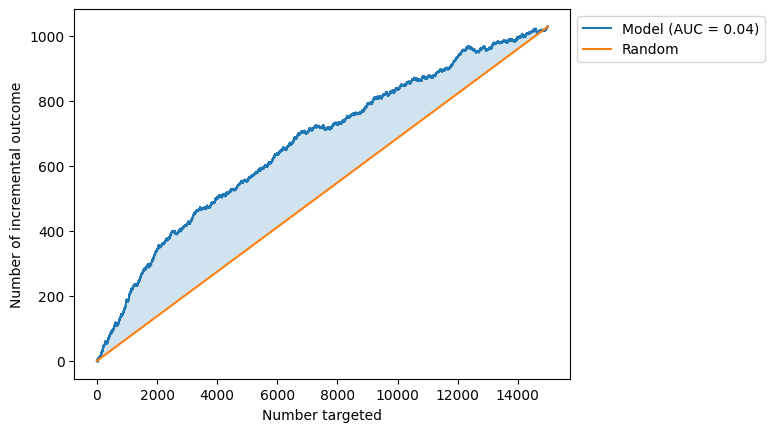

In [20]:
uplift_test = plot_uplift_curve(
    x_learner_cate_test["converted"], x_learner_cate_test["cate"], x_learner_cate_test["em1"],
    perfect=False, name='Model'
)